# Determining Population Densities and Intramicellar Distributions by Contrast Variation SANS

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve with soft ball P(Q) in J. Chem. Phys. 153, 184902 (2020)
# Calculate polymer distribution by contrast variation (J. Phys. Chem. Lett. 2020, 11, 17, 7334–7341)
#
# tensorflow 2.6.0

In [2]:
# 2022 dilute CV SANS results from Bailee Barrett/Zhang Research Group, February 02, 2022

## Setup

Ensure you have installed these packages first  
``$ pip install tensorflow-probabilit``  
``$ pip install imageio``  
``$ pip install git+https://github.com/tensorflow/docs``  

In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.io import savemat, loadmat
tf.config.run_functions_eagerly(True)
from SQ_decoder import SQ_decoder

In [4]:
seq_name = 'S5'

In [5]:
fp_path = './cv_SANS/fp/' + seq_name + '/'

In [6]:
#load VAE S(Q)
def SQ_th(fp):
    # structure factor
    return SQ_decoder(fp[7:10])

loaded_data = loadmat('./BB_CVSANS/'+seq_name+'.mat')
fp_loaded = loaded_data['fp'][0]
SQ_VAE = SQ_th(fp_loaded)


## Define functions

### Load data

In [7]:
def is_header(x):
    n_header = 2
    return x>=n_header

In [8]:
def loaddata(filename):
#     filename = data_path + 'BB-CVSANS-S5-{:03d}.txt'.format(i)
    with open(filename,'r') as fp:
        lines = fp.readlines()

    index_all = range(len(lines))
    index = list(filter(is_header, index_all))
    
    lines_data = list(itemgetter(*index)(lines))
    
    data_dict = {}
    for j, ld in enumerate(lines_data):
        raw_fields = struct_unpacker(ld.encode())
        ld_unpacked = {}
        for i in field_indices:
            fieldspec = fieldspecs[i]
            fieldname = fieldspec[iname]
            cast = fieldspec[itype]
            value = cast(raw_fields[i].decode().strip())
            ld_unpacked[fieldname] = [value]
        if j==0:
            data_dict = ld_unpacked
            continue
        data_dict = {key: [*data_dict[key], *ld_unpacked[key]] for key in data_dict}
    
    return data_dict

In [9]:
def get_struct_unpacker(fieldspecs, istart, iwidth):
    # https://gist.github.com/rochacbruno/059e1223f5b69d3b99b509a4962cf3aa
    """
    Build the format string for struct.unpack to use, based on the fieldspecs.
    fieldspecs is a list of [name, start, width] arrays.
    Returns a string like "6s4s8s7x7s4x9s".
    """
    unpack_len = 0
    unpack_fmt = ""
    for fieldspec in fieldspecs:
        start = fieldspec[istart] - 1
        end = start + fieldspec[iwidth]
        if start > unpack_len:
            unpack_fmt += str(start - unpack_len) + "x"
        unpack_fmt += str(end - start) + "s"
        unpack_len = end
    struct_unpacker = struct.Struct(unpack_fmt).unpack_from
    return struct_unpacker

In [10]:
from operator import itemgetter
import struct

fieldspecs = [
    # Name, Start, Width, Type
    ["Q (1/A)", 1, 12, float],
    ["I(Q) (1/cm)", 14, 12, float],
    ["std. dev. I(Q) (1/cm)", 27, 12, float],
    ["sigmaQ", 40, 12, float],
#     ["meanQ", 72, 8, float],
#     ["ShadowFactor", 95, 1, int]
]

iname, istart, iwidth, itype = 0, 1, 2, 3  # field indexes

fieldspecs.sort(key=itemgetter(istart))
struct_unpacker = get_struct_unpacker(fieldspecs, istart, iwidth)
field_indices = range(len(fieldspecs))

### Fit curve

The `initialize` function loads the `fpi_*.csv` file from `fp_path` and read the initial guess, upper bound and lower bound from the columns.

In [11]:
def initialize(contrast):
    fpiname = fp_path + 'fpi_' + seq_name + '_{:03d}.csv'.format(contrast)
    fpi = np.genfromtxt(fpiname, delimiter=',')
    
    fp_i = list(fpi[:,0])
    fp_ubounds = tuple(fpi[:,2])
    fp_lbounds = tuple(fpi[:,1])
    fp_bounds = [fp_lbounds,fp_ubounds]
    return fp_i, fp_bounds

In [12]:
def export_fp(fp, contrast):
    fp_array = fp
    fpname = fp_path + 'fp_' + seq_name + '_{:03d}.csv'.format(contrast)
    np.savetxt(fpname, fp_array, delimiter=",") # export fitting parameters

### Generate image

In [13]:
def generate_image_Q(ax, filename, fp, Q, IQ, IQ_er, counter):
    P = softball_Q(Q, fp)
    IQ_fp = fp[0]*P*SQ_VAE + fp[1]
    IQ_fp_res = IQ_th(Q,fp)
    
    loss = np.mean(fit_loss(Q, fp, IQ)**2)
       
    ax[0].clear()
    
    ax[0].errorbar(Q, IQ, yerr=IQ_er, fmt=',k', elinewidth=1, capsize=2)
    ax[0].plot(Q, IQ_fp_res, 'b')
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    
    ax[0].set_xlim(0.02, 0.5)
    ax[0].set_ylim(0.1, 50)
    
    ax[0].text(0.05,0.12,'A = {:0.4f}, B = {:0.4f}, R1 = {:0.4f}, R2 = {:0.4f}'
             .format(fp[0],fp[1],fp[2],fp[3])
             ,transform=ax[0].transAxes)
    ax[0].text(0.05,0.06,'sigma1 = {:0.4f}, sigma2 = {:0.4f}, rc = {:0.4f}'
             .format(fp[4],fp[5],fp[6])
             ,transform=ax[0].transAxes)
    ax[0].text(0.80,0.95,'loss = {:0.4f}'
             .format(loss)
             ,transform=ax[0].transAxes)
    
    ax[0].set_xlabel('$Q$')
    ax[0].set_ylabel('$I(Q)$')
    
    fig.canvas.draw()
    #time.sleep(0.01)

In [14]:
def generate_image_r(ax, filename, fp, Q, IQ, IQ_er, counter):
    r = (np.arange(1000)+1)/10
    Deltarho_m = softball_r(Q, fp, r)
    Deltarho_h = softball_r(Q, [fp[0],fp[1],fp[2],fp[3],1e-4,1e-4,fp[6]], r)
    
    ax[1].clear()
    
    ax[1].plot(r, Deltarho_m, 'b')
    ax[1].plot(r, Deltarho_h, '--k')
    
    #ax[1].set_xscale('log')
    #ax[1].set_yscale('log')
    
    ax[1].set_xlim(0, 100)
    #ax[1].set_ylim(0.02, 2)
    
    ax[1].set_xlabel(r'$r$')
    ax[1].set_ylabel(r'$\Delta\rho_m(r)$')
        
    fig.canvas.draw()
    #time.sleep(0.01)

-----

## Fit I(Q)

In [15]:
# %matplotlib notebook

loaded ./cv_SANS/data/BB-CVSANS-S5-032.dat
d_HS = 109.77629238256819


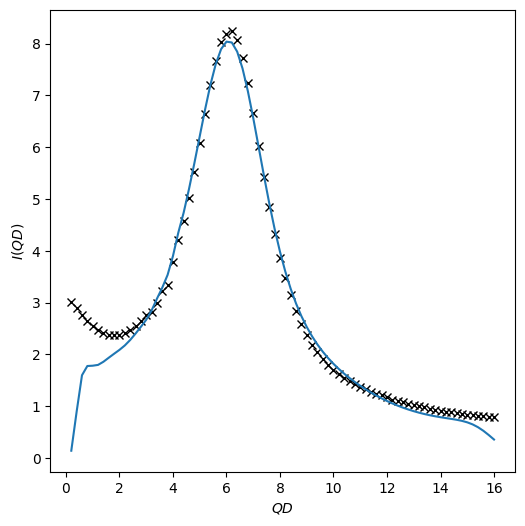

In [16]:
data_path = './cv_SANS/data/'
contrasts = np.array([100, 95, 90, 85, 80, 75])
solvent = ['027', '028', '029', '030', '031', '032']

for ic, contrast in enumerate(contrasts[0:6]):
    display.clear_output(wait=False)
    # Load data
    filename = data_path + 'BB-CVSANS-' + seq_name + '-' + solvent[ic] + '.dat'
    data_dict = loaddata(filename)
    print('loaded '+ filename)
    
    Q = np.array(data_dict['Q (1/A)']).astype(np.float32)
    IQ = np.array(data_dict['I(Q) (1/cm)']).astype(np.float32)
    IQ_er = np.array(data_dict['std. dev. I(Q) (1/cm)']).astype(np.float32)
    dQ = np.array(data_dict['sigmaQ']).astype(np.float32)
    
    '''
    Load Data
    The input data is rescaled to the range such that 0.02<=QD<=16 
    '''
    sq_dim = 80
    sample_dim = 1
    q = (np.arange(sq_dim)+1)*0.2
    q_rs = (np.arange(sq_dim)+1)*0.2
    q_rs_dim = q_rs.shape[0]
    r_HS = 3/0.05465661 # when Q = 0.04112146, Qr_HS = 3 (first peak)
    d_HS = r_HS*2
    print('d_HS = {}'.format(d_HS))
    IQ_rs = np.zeros((sample_dim,q_rs_dim)) 
    Qd_HS = Q*d_HS

    # # extrapolate low-Q
    i_fit = (Qd_HS>1.8) & (Qd_HS<3)
    polycoeff = np.polyfit(Qd_HS[i_fit],IQ[i_fit],2)

    i_lowQ = (Qd_HS<3)
    IQ[i_lowQ] = Qd_HS[i_lowQ]**2*polycoeff[0] + Qd_HS[i_lowQ]**1*polycoeff[1] + Qd_HS[i_lowQ]**0*polycoeff[2]

    # # rescale IQ to QD in [0,16]
    f_IQ = interp.interp1d(Qd_HS[2:],IQ[2:],fill_value='extrapolate')
    IQ_rs = f_IQ(q_rs).astype(np.float32)
    IQ_rs[IQ_rs<=0] = 1e-5

    # # rescale IQ_er to QD in [0,16]
    f_IQ_er = interp.interp1d(Qd_HS[2:],IQ_er[2:],fill_value='extrapolate')
    IQ_er_rs = f_IQ_er(q_rs).astype(np.float32)
    
    interpolating_function_dQ = interp.interp1d(Qd_HS[3:],dQ[3:],fill_value='extrapolate',kind= 'linear')
    dQ_interp = interpolating_function_dQ(q).astype(np.float32)
    dQ_sm = sgnl.savgol_filter(dQ_interp,5,3)
    
    '''
    Define Functions
    '''
    def softball_Q(Q, fp):
        R1, R2, sigma1, sigma2 = fp[2:6]
        R1 = R1/d_HS
        R2 = R2/d_HS
        sigma1 = sigma1/d_HS 
        sigma2 = sigma2/d_HS
        
        rc = fp[6]
        j1 = lambda QR: (tf.math.sin(QR)-QR*tf.math.cos(QR))/QR**2
        F1 = lambda QR, Qsigma: 3*j1(QR)*tf.math.exp(-(Qsigma/2)**2)/QR

        QR1 = Q*R1
        QR2 = Q*R2
        Qsigma1 = Q*sigma1
        Qsigma2 = Q*sigma2

        P = (rc*F1(QR1,Qsigma1) + (1-rc)*F1(QR2,Qsigma2))**2

        return P


    def IQ_resoln(Q, Q_fine, IQ_th, dQ):
        '''
        Q: Q of the instrument resolution function
        Q_fine: A set of smooth Q points
        IQ_th: I(Q), interpolated to Q_fine
        dQ: The instrument resolution function
        '''

        Qmean = Q
        N = len(Q)
        IQ = []

        for i in range(N):
            current_dQ = dQ[i]
            current_Qmean = Qmean[i]
            IQ_resoln = IQ_th*(1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
            IQ.append(np.trapz(IQ_resoln,Q_fine))

        IQ_out = np.array(IQ)
        return IQ_out

    def interpolation(q,x,scale):
        qs = q*scale
        f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
        x_interp = f_interp(q)
        return x_interp

    def IQ_th(fp):
        # form factor
        P = softball_Q(q, fp)

        # structure factor
        S = SQ_VAE

        # I(Q)
        IQ_th = S*P*fp[0]+fp[1]

        # interpolation
        IQ_th_interp = interpolation(q,IQ_th,fp_loaded[10])

        # resolution
        IQ_th_smooth = IQ_resoln(q, q[1:], IQ_th_interp[1:], dQ_sm*r_HS*2*fp_loaded[10])
        return IQ_th_smooth

    '''
    Fit
    '''
    def Fit_loss(fp):
        return ((IQ_rs)-(IQ_th(fp)))[(q>=3)&(q<=15)]
    #     return (np.log(IQ_exp)-np.log(IQ_th(fp)))[(q>=1)&(q<=16)]
    
    fp, fp_bounds = initialize(contrast)
    
    opti = opt.least_squares(Fit_loss,fp,bounds=fp_bounds, 
                         xtol = 1e-14, ftol = 1e-14,
                         x_scale='jac',method='trf',
                         jac='3-point')
    fp = opti.x
    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1)

    # ax.errorbar(q,IQ_rs,yerr=IQ_er_rs,fmt='k')
    ax.plot(q,IQ_rs,'xk')
    ax.plot(q,IQ_th(fp))

    ax.set_xlabel(r'$QD$')
    ax.set_ylabel(r'$I(QD)$')

    # ax.set_yscale('log')
    plt.show()
    
    export_fp(fp, contrast)
    

## Contrast variation

### Generate $\rho_m(r,\gamma)$

In [17]:
def softball_r(fp, r = (np.arange(100)+1)):
    R1, R2, sigma1, sigma2 = np.array(fp[2:6])/fp_loaded[10]
    rc = fp[6]
    from scipy.special import erf   
    Deltarho1 = lambda r, R, sigma: 3/(8*np.pi*R**3)*(erf((r+R)/sigma)-erf((r-R)/sigma)
                                    +(np.exp(-((r+R)/sigma)**2)-np.exp(-((r-R)/sigma)**2))/(np.sqrt(np.pi)*r)
                                    )

    Deltarho_m = -(rc*Deltarho1(r, R1, sigma1) + (1-rc)*Deltarho1(r, R2, sigma2))

    return Deltarho_m

def softball_Qf(Q, fp):
    R1, R2, sigma1, sigma2 = fp[2:6]
    R1 = R1
    R2 = R2
    sigma1 = sigma1
    sigma2 = sigma2

    rc = fp[6]
    j1 = lambda QR: (tf.math.sin(QR)-QR*tf.math.cos(QR))/QR**2
    F1 = lambda QR, Qsigma: 3*j1(QR)*tf.math.exp(-(Qsigma/2)**2)/QR

    QR1 = Q*R1
    QR2 = Q*R2
    Qsigma1 = Q*sigma1
    Qsigma2 = Q*sigma2

    P = (rc*F1(QR1,Qsigma1) + (1-rc)*F1(QR2,Qsigma2))**2

    return P

In [18]:
r = (np.arange(1000)+1)/5
Qf = (np.arange(1000)+1)/1000*0.12

In [19]:
fpc = np.zeros((len(contrasts),7))
Deltarho_m_c = np.zeros((len(contrasts),1000))
IQ_r = np.zeros((len(contrasts),1000))
PQ = np.zeros((len(contrasts),1000))

fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
for i, contrast in enumerate(contrasts[0:5]):
    # Load data
    fpname = fp_path + 'fp_' + seq_name + '_{:03d}.csv'.format(contrast)
    fpc[i,:] = np.genfromtxt(fpname, delimiter=',')
    
    rho = softball_r(fpc[i,:], r)
    A = fpc[i,0]*1e-8 # angstrom^-1
    
    
#     IQ_r[i,:] = fpc[i,0]*softball_Q(Qf, fpc[i,:]) + fpc[i,1]
    f_interp_IQ = interp.interp1d(q/d_HS,IQ_th(fpc[i,:]),fill_value='extrapolate')
    IQ_r[i,:] = f_interp_IQ(Qf)
        
    Deltarho_m_c[i,:] = rho*np.sqrt(A) # n_m^(1/2)*Deltarho(r)
    ax.plot(r,Deltarho_m_c[i,:],'-',color=((5/6-i/6),(5/6-i/6),(5/6-i/6)))
    
    PQ[i,:] = softball_Qf(Qf, fpc[i,:])

fig.canvas.draw()
Deltarho_m_c = Deltarho_m_c.T
IQ_r = IQ_r.T
PQ = PQ.T

rhoname = fp_path + 'rho_' + seq_name + '.csv'
np.savetxt(rhoname, np.vstack((r,Deltarho_m_c.T)).T, delimiter=",") # save Deltarho_m^n(r)

IQname = fp_path + 'IQ_fit_' + seq_name + '.csv'
np.savetxt(IQname, np.vstack((Qf,IQ_r.T)).T, delimiter=",") # save fitted I(Q)

PQname = fp_path + 'PQ_fit_' + seq_name + '.csv'
np.savetxt(PQname, np.vstack((Qf,PQ.T)).T, delimiter=",") # save fitted I(Q)

### $\frac{d}{d\gamma} \Delta\rho_m^n(r)$

In [20]:
b = np.zeros((1000,2))
e = np.zeros((1000,6))
b_er = np.zeros(1000)
for j in range(1000):
    X = np.vstack((np.ones(6),contrasts/100))
    Y = Deltarho_m_c[j,:]
    b[j,:] = (np.linalg.inv(X@(X.T))@X)@Y
    e[j,:] = Y-b[j,:]@X
    b_er[j] = np.std(e[j,:]/(6-2))/np.std(contrasts/100)

### Scattering length density and molecular weight

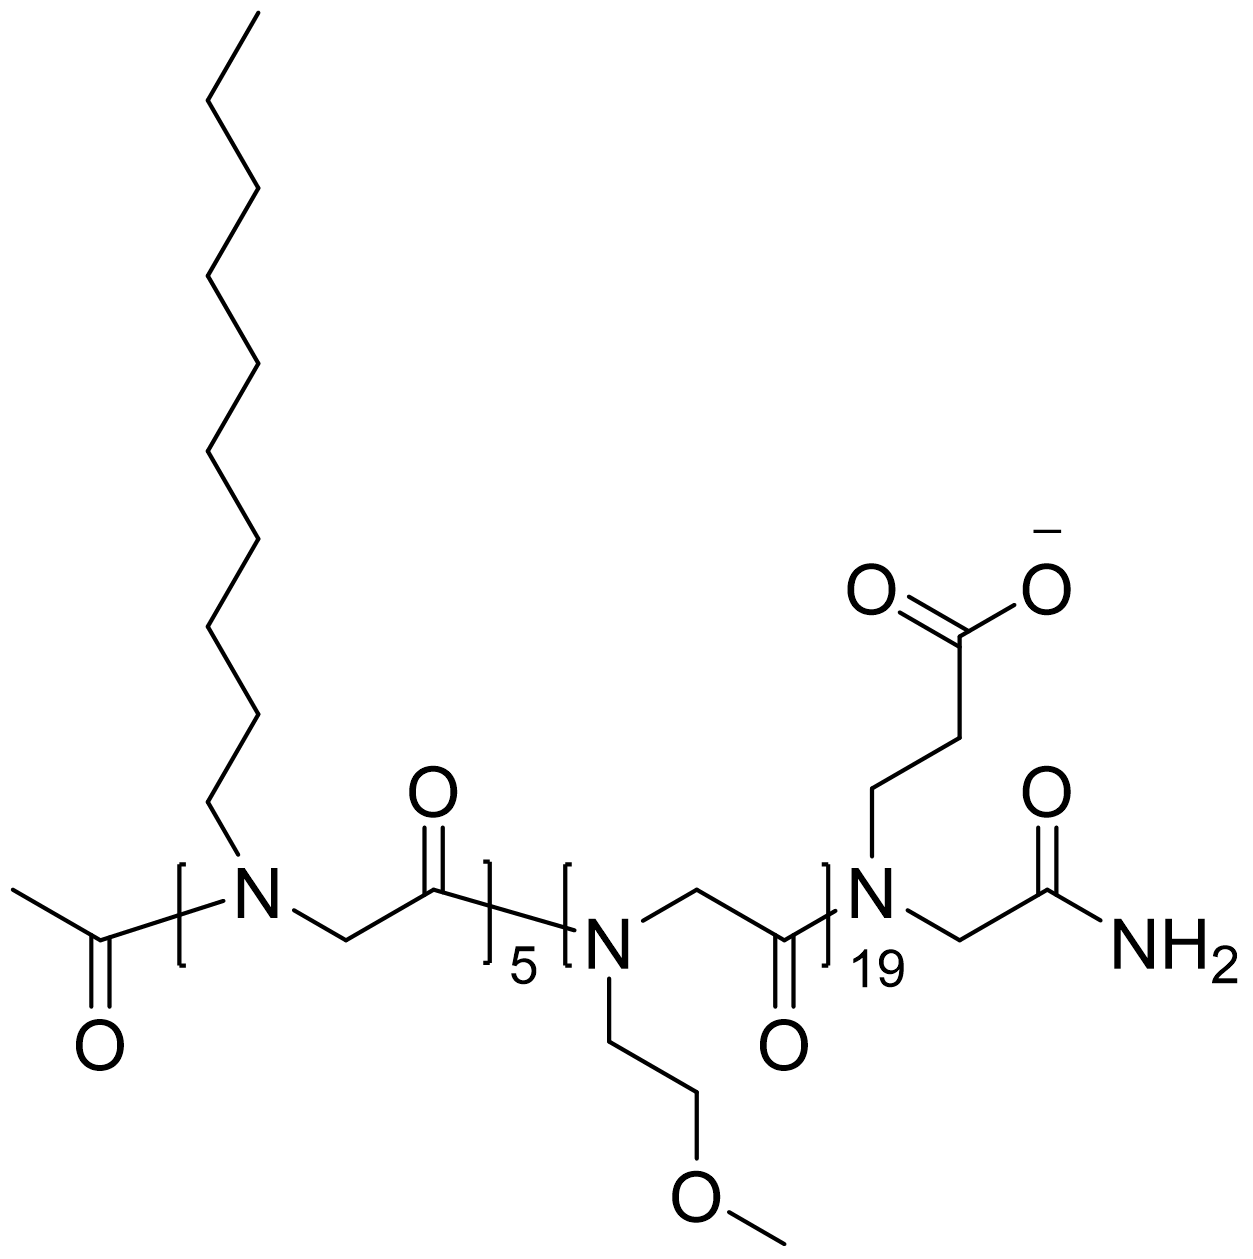

In [21]:
display.Image('../../data/skeletal.png',width = 300, height = 300)

In [22]:
N_A = 6e23
bO = 5.803e-5 # angstrom
bC = 6.6460e-5
bS = 2.847e-5
bN = 9.36e-5
bD = 6.671e-5
bH = -3.7390e-5
bpol = ((bC+bH*3+bC+bO)
        +(bN+(bC*10+bH*21)+bC+bH*2+bC+bO)*5
        +(bN+(bC*2+bH*4+bO+bC+bH*3)+bC+bH*2+bC+bO)*19
        +(bN+bC*3+bH*4+bO*2)+bC+bH*2+bC+bO+(bN+bH*2)       
       )
# bpol = bC*162 + bH*297 + bN*26 + bO*47
bH2O = 2*bH + bO
bD2O = 2*bD + bO
Mw = 3361.29
     #((12+1*3+12+16)
      #+(14+(12*10+1*21)+12+1*2+12+16)*5
      #+(14+(12*2+1*4+16+12+1*3)+12+1*2+12+16)*19
      #+(14+12*3+1*4+16*2)+12+1*2+12+16+(14+1*2)       
      #)
vu = Mw/0.99/N_A/1e-24 # angstrom^3
vw = 18/1/N_A/1e-24
Conc = 2e-1/Mw/1e24*N_A # angstrom-^3 

### Calculate $n_m$, $H(r)$

In [23]:
Hc = 0.0
n_m = (vw/(1-Hc)/(bD2O-bH2O)*b[0,1])**2
n_m_er = (vw/(bD2O-bH2O)*b_er[0])**2
H = 1/vw + np.sqrt(1/n_m)/(bD2O-bH2O)*b[:,1]
H_er = np.sqrt(1/n_m)/(bD2O-bH2O)*b_er[:]

HH = np.vstack((r,H,H_er)).T
HHname = fp_path + 'H_' + seq_name + '.csv'
np.savetxt(HHname, HH, delimiter=",") # save H(r)

### Calculate $P(r)$, $N_{agg}$, $R_g$, $R_b$, $n_u$, $f_m$, $\phi_m$

In [24]:
P = -(H-1/vw)*vw/vu
P_er = (H_er)*vw/vu

PP = np.vstack((r,P,P_er)).T
PPname = fp_path + 'P_' + seq_name + '.csv'
np.savetxt(PPname, PP, delimiter=",") # save P(r)

v_ew = -vw*4*np.pi*np.trapz((H-1/vw)*r**2, r)
v_ew_er = vw*4*np.pi*np.trapz((H_er)*r**2, r)

N_agg = v_ew/vu-1
N_agg_er = v_ew_er/vu

Rg = np.sqrt(np.trapz(P*r**4, r)/np.trapz(P*r**2, r))
Rg_er = Rg*((1+v_ew_er/v_ew)**(1/3)-1)

for j in range(1000):
    n_poly = 4*np.pi*np.trapz(P[0:j+1]*r[0:j+1]**2, r[0:j+1])
    if n_poly>N_agg:
        break
Rb = r[j]
Rb_er = Rb*((1+v_ew_er/v_ew)**(1/3)-1)

n_u = Conc-n_m*N_agg
n_u_er = np.sqrt((n_m_er*N_agg)**2 + (n_m*N_agg_er)**2)/2

f_m = n_m*N_agg/(Conc)
f_m_er = np.sqrt((n_m_er*N_agg)**2 + (n_m*N_agg_er)**2)/(Conc)/2

phi_m = n_m*4/3*np.pi*Rb**3
phi_m_er = phi_m*np.sqrt((n_m_er/n_m)**2 + 3*(Rb_er/Rb)**2)/2

---

## Summary

In [25]:
%matplotlib notebook

In [26]:
parameters = {'n_m':n_m, 'N_agg':N_agg, 'Rg':Rg, 'Rb':Rb, 'n_u':n_u, 'f_m':f_m, 'phi_m':phi_m, 
              'H':H, 'P':P, 
              'n_m_er':n_m_er, 'N_agg_er':N_agg_er, 'Rg_er':Rg_er, 'Rb_er':Rb_er, 'n_u_er':n_u_er, 'f_m_er':f_m_er, 'phi_m_er':phi_m_er, 
              'H_er':H_er, 'P_er':P_er,
              'Deltarho_m_c':Deltarho_m_c, 'IQ_r':IQ_r}
np.save(fp_path + 'parameters.npy', parameters)
savemat(fp_path + 'parameters.mat', parameters)

print('n_m   = {:0.4e} ± {:0.4e}, N_agg = {:0.4e} ± {:0.4e}, \nRg    = {:0.4e} ± {:0.4e}, Rb    = {:0.4e} ± {:0.4e}, '
      .format(n_m,n_m_er,N_agg,N_agg_er,Rg,Rg_er,Rb,Rb_er))
print('n_u   = {:0.4e} ± {:0.4e}, f_m   = {:0.4e} ± {:0.4e}, \nphi_m = {:0.4e} ± {:0.4e}'
      .format(n_u,n_u_er,f_m,f_m_er,phi_m,phi_m_er))

with open(fp_path + 'parameters.txt', mode='w', encoding='iso-8859-1') as file_object:
    print('n_m   = {:0.4e} ± {:0.4e}, N_agg = {:0.4e} ± {:0.4e}, \nRg    = {:0.4e} ± {:0.4e}, Rb    = {:0.4e} ± {:0.4e}, '
      .format(n_m,n_m_er,N_agg,N_agg_er,Rg,Rg_er,Rb,Rb_er), file=file_object)
    print('n_u   = {:0.4e} ± {:0.4e}, f_m   = {:0.4e} ± {:0.4e}, \nphi_m = {:0.4e} ± {:0.4e}'
      .format(n_u,n_u_er,f_m,f_m_er,phi_m,phi_m_er), file=file_object)

n_m   = 2.2570e-06 ± 2.1286e-07, N_agg = 4.0193e+01 ± 7.4571e+00, 
Rg    = 3.8692e+01 ± 2.2066e+00, Rb    = 6.5600e+01 ± 3.7411e+00, 
n_u   = -5.5014e-05 ± 9.4402e-06, f_m   = 2.5410e+00 ± 2.6443e-01, 
phi_m = 2.6689e+00 ± 1.8225e-01


<IPython.core.display.Javascript object>


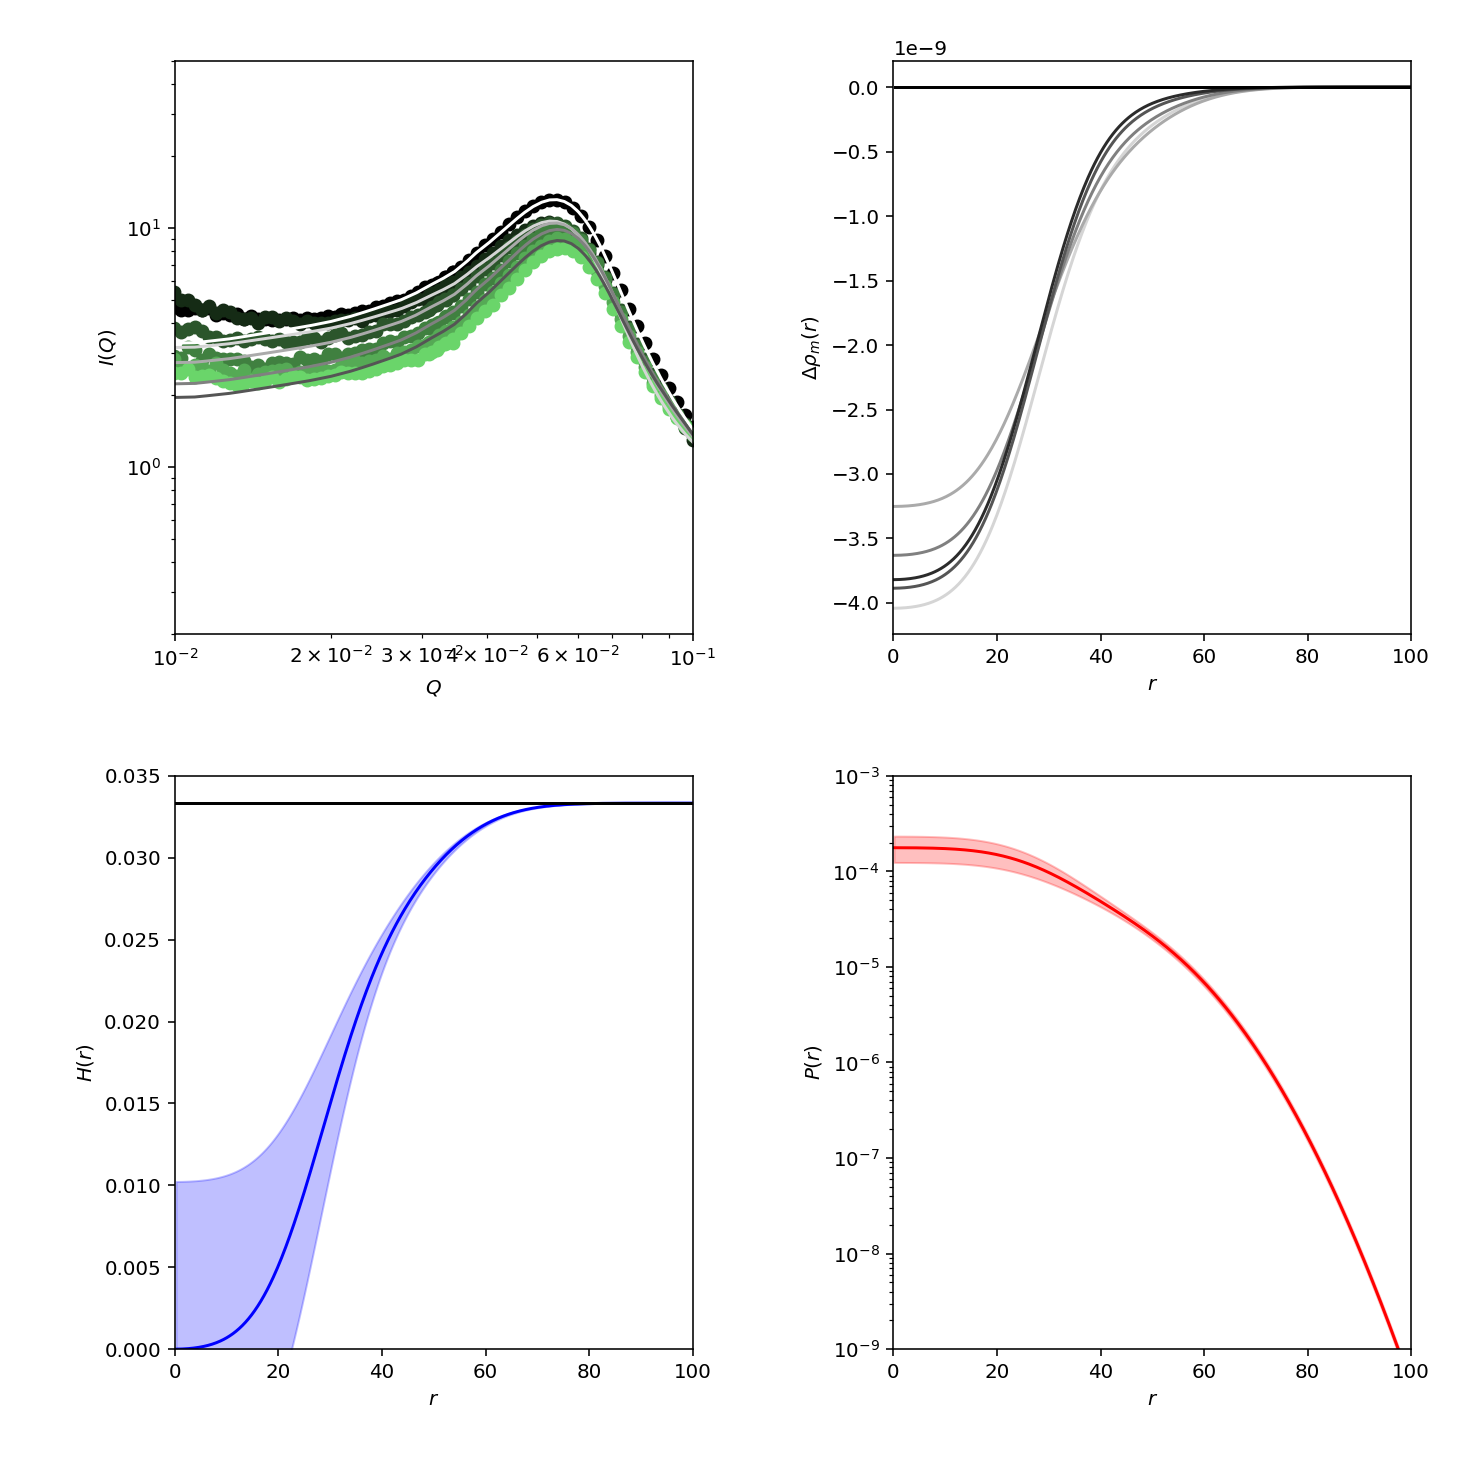

In [27]:
fig,ax = plt.subplots(2,2, figsize=[7.2, 7.2])
data_path = './cv_SANS/data/'
contrasts = np.array([100, 95, 90, 85, 80, 75])
solvent = ['027', '028', '029', '030', '031', '032']

# fitting results
for i, contrast in enumerate(contrasts):
    # Load data
    filename = data_path + 'BB-CVSANS-' + seq_name + '-' + solvent[i] + '.dat'
    data_dict = loaddata(filename) 
    Q = np.array(data_dict['Q (1/A)']).astype(np.float32)
    IQ = np.array(data_dict['I(Q) (1/cm)']).astype(np.float32)
    IQ_er = np.array(data_dict['std. dev. I(Q) (1/cm)']).astype(np.float32)   
    ax[0,0].plot(Q,IQ,'o',color=(i/12,i/6,i/12))
for i, contrast in enumerate(contrasts):
    ax[0,0].plot(Qf,IQ_r[:,i],'-',color=((1-i/6),(1-i/6),(1-i/6)))
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0.01, 0.1)
ax[0,0].set_ylim(0.2, 50)
ax[0,0].set_xlabel('$Q$')
ax[0,0].set_ylabel('$I(Q)$')

# rho_m^n(r)
for i, contrast in enumerate(contrasts):
    ax[0,1].plot(r,Deltarho_m_c[:,i],'-',color=((5/6-i/6),(5/6-i/6),(5/6-i/6)))
ax[0,1].set_xlim(0, 100)
ax[0,1].set_xlabel(r'$r$')
ax[0,1].set_ylabel(r'$\Delta\rho_m(r)$')

# H(r)
ax[1,0].fill_between(r,H-H_er,H+H_er,color='b',alpha=0.25)
ax[1,0].plot(r,H,'b')
ax[1,0].plot(r,np.ones(r.shape)*(1/vw),'k')
#ax[1,0].set_xscale('log')
#ax[1,0].set_yscale('log')
ax[1,0].set_xlim(0, 100)
ax[1,0].set_ylim(0, 0.035)
ax[1,0].set_xlabel(r'$r$')
ax[1,0].set_ylabel(r'$H(r)$')

# P(r)
ax[1,1].fill_between(r,P-P_er,P+P_er,color='r',alpha=0.25)
ax[1,1].plot(r,P,'r')
#ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlim(0, 100)
ax[1,1].set_ylim(1e-9, 1e-3)
ax[1,1].set_xlabel(r'$r$')
ax[1,1].set_ylabel(r'$P(r)$')

fig.tight_layout()
fig.canvas.draw()

<IPython.core.display.Javascript object>


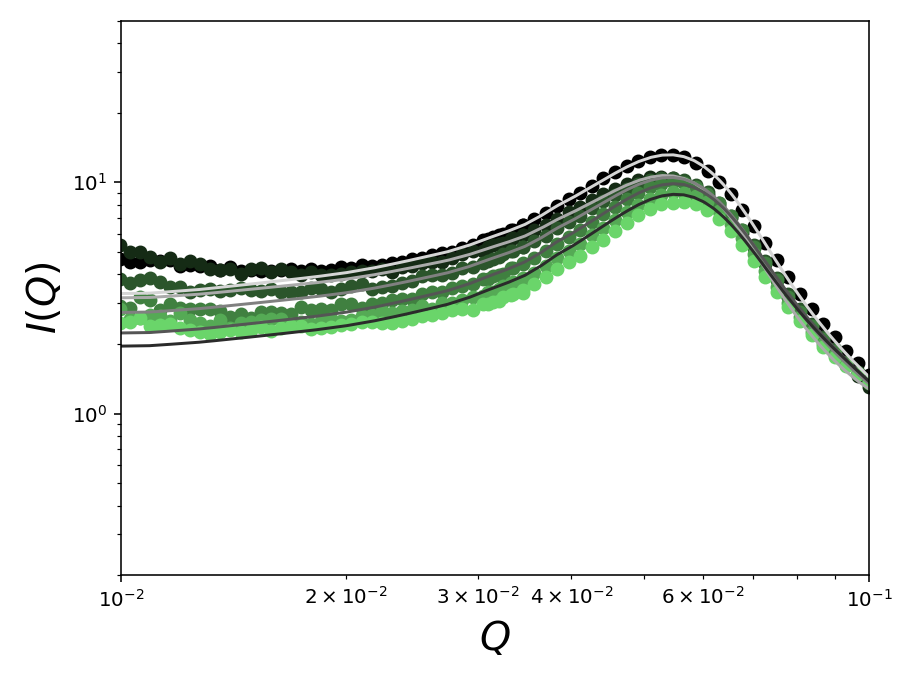

In [28]:
fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
data_path = './cv_SANS/data/'
contrasts = np.array([100, 95, 90, 85, 80, 75])
solvent = ['027', '028', '029', '030', '031', '032']

# fitting results
for i, contrast in enumerate(contrasts):
    # Load data
    filename = data_path + 'BB-CVSANS-' + seq_name + '-' + solvent[i] + '.dat'
    data_dict = loaddata(filename) 
    Q = np.array(data_dict['Q (1/A)']).astype(np.float32)
    IQ = np.array(data_dict['I(Q) (1/cm)']).astype(np.float32)
    IQ_er = np.array(data_dict['std. dev. I(Q) (1/cm)']).astype(np.float32)   
    ax.plot(Q,IQ,'o',color=(i/12,i/6,i/12))
for i, contrast in enumerate(contrasts):
    ax.plot(Qf,IQ_r[:,i],'-',color=((5/6-i/6),(5/6-i/6),(5/6-i/6)))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 0.1)
ax.set_ylim(0.2, 50)
ax.set_xlabel('$Q$',fontsize=20)
ax.set_ylabel('$I(Q)$',fontsize=20)

pngname = './figures/' + seq_name + '/IQfit_' + seq_name + '.png'
fig.tight_layout()
plt.savefig(pngname.format(contrast))

<IPython.core.display.Javascript object>


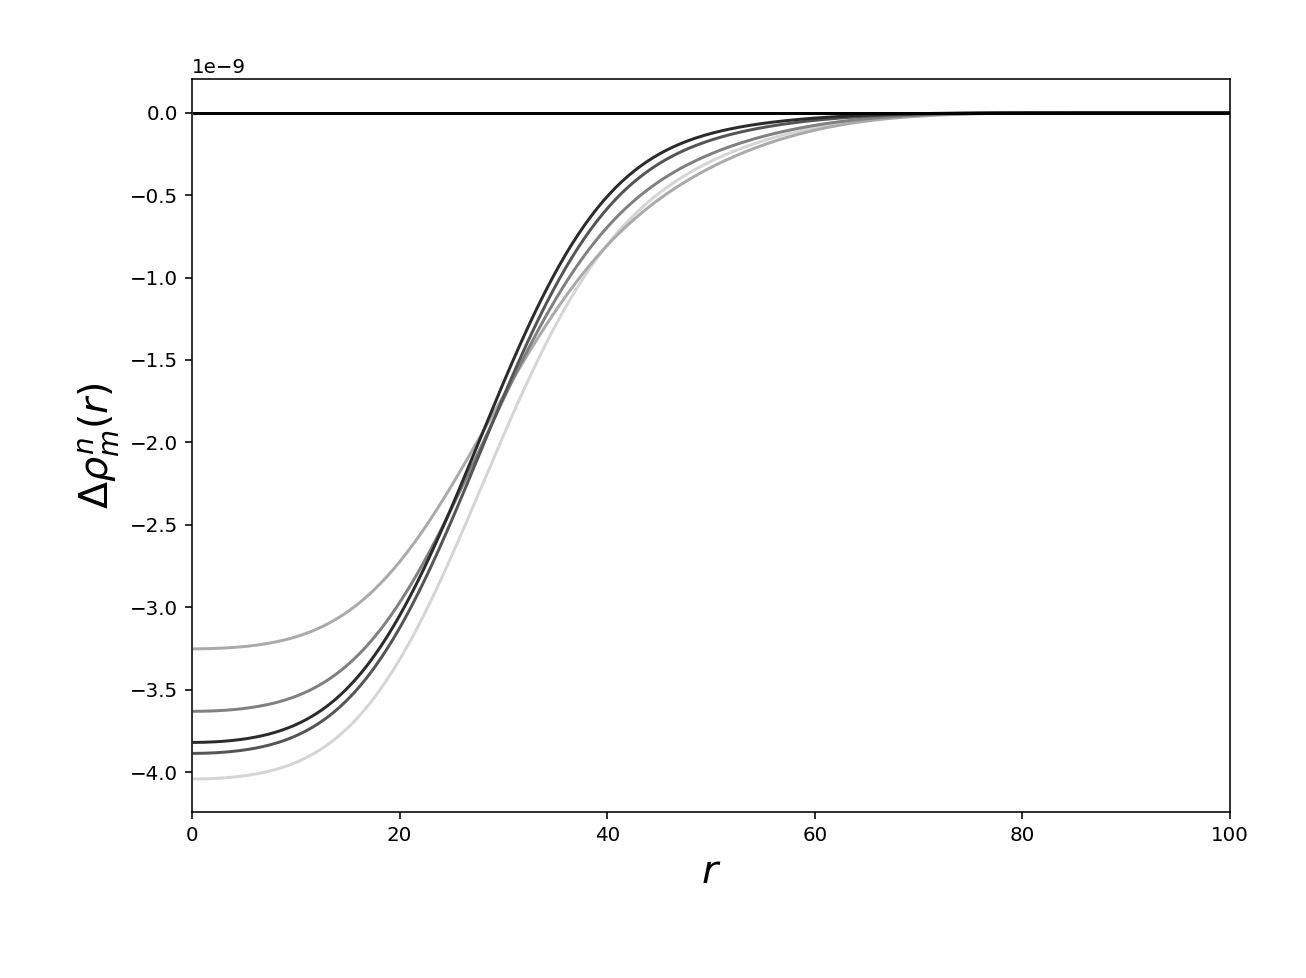

In [29]:
fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
plt.rcParams['font.size'] = '16'

# rho_m^n(r)
for i, contrast in enumerate(contrasts):
    ax.plot(r,Deltarho_m_c[:,i],'-',color=((5/6-i/6),(5/6-i/6),(5/6-i/6)))
ax.set_xlim(0, 100)
ax.set_xlabel(r'$r$',fontsize=20)
ax.set_ylabel(r'$\Delta\rho_m^n(r)$',fontsize=20)

pngname = './figures/' + seq_name + '/rho_m_' + seq_name + '.png'
fig.tight_layout()
plt.savefig(pngname.format(contrast))

<IPython.core.display.Javascript object>


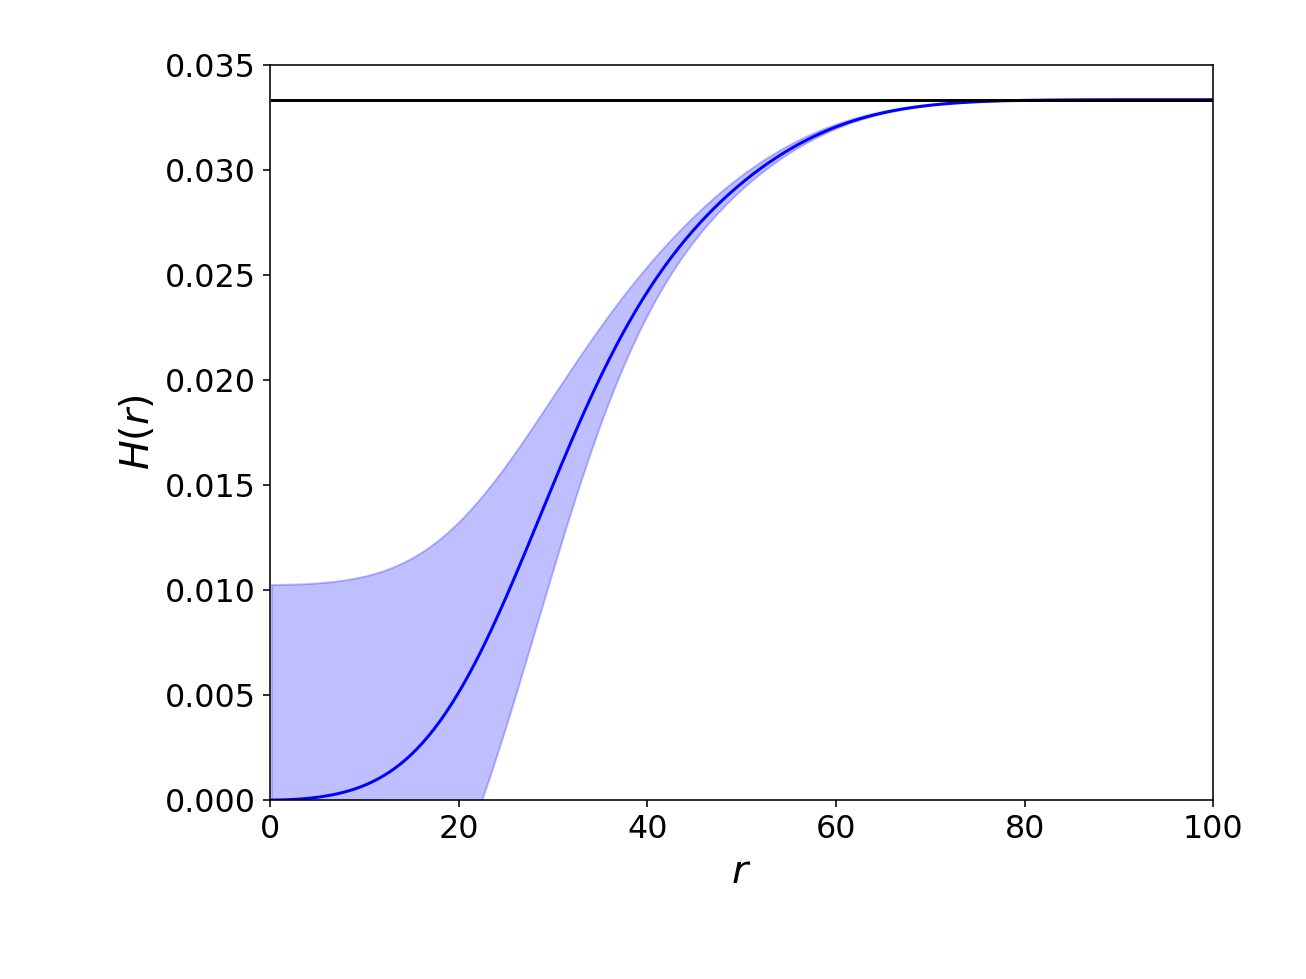

In [30]:
fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
plt.rcParams['font.size'] = '16'

# H(r)
ax.fill_between(r,H-H_er,H+H_er,color='b',alpha=0.25)
ax.plot(r,H,'b')
ax.plot(r,np.ones(r.shape)*(1/vw),'k')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.035)
ax.set_xlabel(r'$r$',fontsize=20)
ax.set_ylabel(r'$H(r)$',fontsize=20)

pngname = './figures/' + seq_name + '/H_' + seq_name + '.png'
fig.tight_layout()
plt.savefig(pngname.format(contrast))

<IPython.core.display.Javascript object>


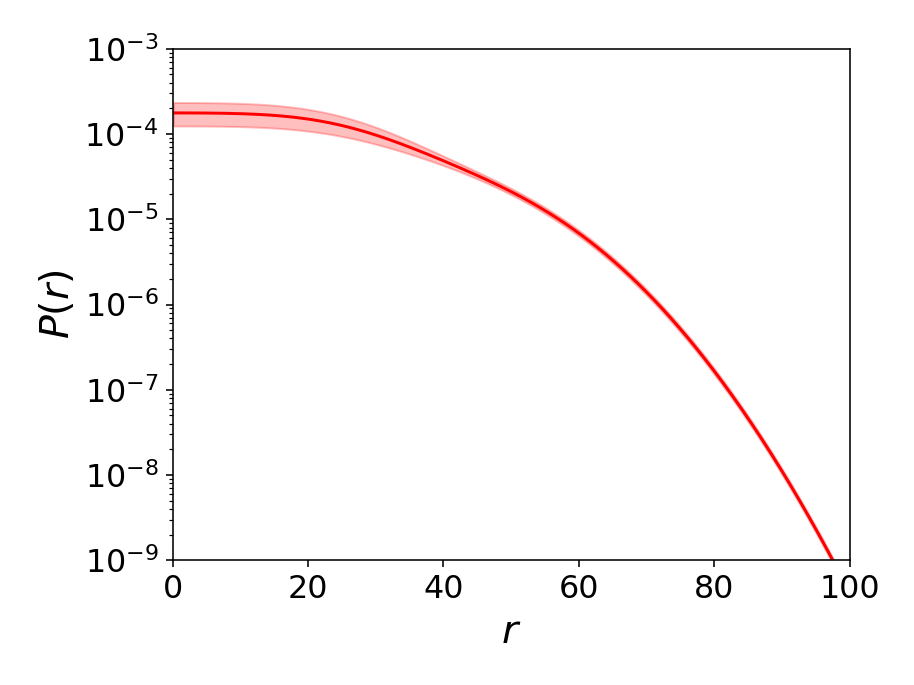

In [31]:
fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
plt.rcParams['font.size'] = '16'

# P(r)
ax.fill_between(r,P-P_er,P+P_er,color='r',alpha=0.25)
ax.plot(r,P,'r')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 100)
ax.set_ylim(1e-9, 1e-3)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$P(r)$')
ax.set_xlabel(r'$r$',fontsize=20)
ax.set_ylabel(r'$P(r)$',fontsize=20)

pngname = './figures/' + seq_name + '/P_' + seq_name + '.png'
fig.tight_layout()
plt.savefig(pngname.format(contrast))

<IPython.core.display.Javascript object>


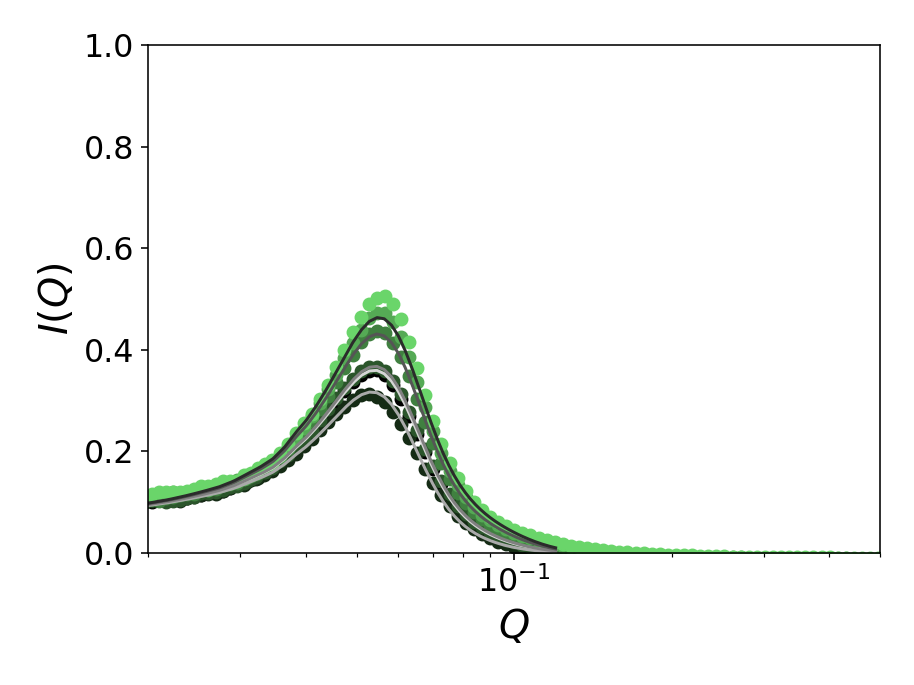

In [32]:
fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
plt.rcParams['font.size'] = '16'

# fitting results
for i, contrast in enumerate(contrasts):
    # Load data
    fpname = fp_path + 'fp_' + seq_name + '_{:03d}.csv'.format(contrast)
    fpc[i,:] = np.genfromtxt(fpname, delimiter=',')
    A = fpc[i,0]
    B = fpc[i,1]

    filename = data_path + 'BB-CVSANS-' + seq_name + '-' + solvent[i] + '.dat'
    data_dict = loaddata(filename) 
    Q = np.array(data_dict['Q (1/A)']).astype(np.float32)
    IQ = np.array(data_dict['I(Q) (1/cm)']).astype(np.float32)
    IQ_er = np.array(data_dict['std. dev. I(Q) (1/cm)']).astype(np.float32)   
#     ax.plot(Q,IQ,'o',color=(i/12,i/6,i/12))  
    ax.plot(Q,(IQ-B)/A,'o',color=(i/12,i/6,i/12))
for i, contrast in enumerate(contrasts):
    # Load data
    fpname = fp_path + 'fp_' + seq_name + '_{:03d}.csv'.format(contrast)
    fpc[i,:] = np.genfromtxt(fpname, delimiter=',')
    A = fpc[i,0]
    B = fpc[i,1]
    ax.plot(Qf,(IQ_r[:,i]-B)/A,'-',color=((5/6-i/6),(5/6-i/6),(5/6-i/6)))
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.02, 0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('$Q$',fontsize=20)
ax.set_ylabel('$I(Q)$',fontsize=20)

pngname = './figures/' + seq_name + '/IQscaled_' + seq_name + '.png'
fig.tight_layout()
plt.savefig(pngname.format(contrast))